In [40]:
import os
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage import measure
from skimage.measure import regionprops


In [41]:
car_image = imread("Test/car.jpg",as_gray=True)
print(car_image.shape)

(3456, 5184)


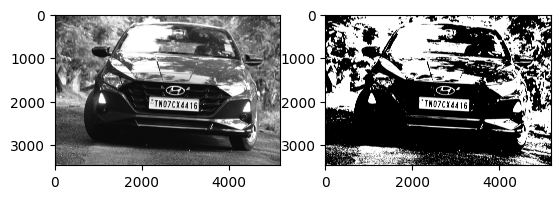

In [42]:
gray_car_image = car_image*255
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image,cmap="gray")
plt.show("Binary image(otsu)")

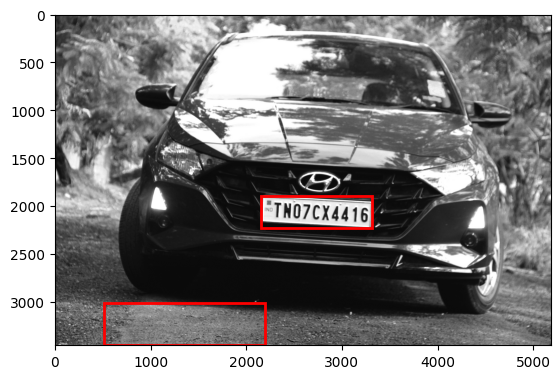

In [43]:
#cca(Connected Component Analysis)
#this gets all the connected regions together  and groups them together
label_image = measure.label(binary_car_image)

plate_dimensions = (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions
plate_objects_cordinates = []
plate_like_objects = []
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray")

# regionprops creates a list of properties of all the labelled regions
for region in regionprops(label_image):
    if region.area < 50:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    region_height = max_row - min_row
    region_width = max_col - min_col
    # ensuring that the region identified satisfies the condition of a typical license plate
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        plate_like_objects.append(binary_car_image[min_row:max_row,
                                  min_col:max_col])
        plate_objects_cordinates.append((min_row, min_col,
                                              max_row, max_col))
        rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
    # let's draw a red rectangle over those regions

plt.show()

    

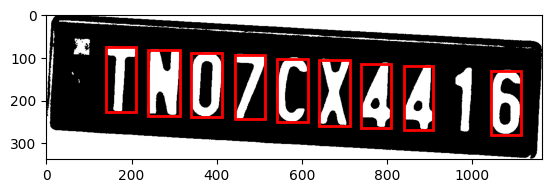

In [44]:
#Character Segmentation
import numpy as np

license_plate = np.invert(plate_like_objects[0])
labelled_plate = measure.label(license_plate)

fig,ax1 = plt.subplots(1)

ax1.imshow(license_plate,cmap = "gray")

character_dimensions = (0.35*license_plate.shape[0],0.60*license_plate.shape[0],0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = np.resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)

plt.show()



In [83]:
#Character Recognition
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import joblib
from skimage.io import imread
from skimage.filters import threshold_otsu


letters =[
              '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
]

def read_training_data(training_direcotry):
    image_data =[]
    target_data=[]
    for each_letter in letters:
        for each in range(10):
            image_path = os.path.join(training_direcotry,each_letter,each_letter + '_'+str(each) + '.jpg')
            #read image of each character
            img_details = imread(image_path,as_gray=True)
            #converts each character image into binary
            binary_image = img_details < threshold_otsu(img_details)
            # the 2D array of each image is flattened because the machine learning
            # classifier requires that each sample is a 1D array
            # therefore the 20*20 image becomes 1*400
            # in machine learning terms that's 400 features with each pixel
            # representing a feature
            flat_bin_image = binary_image.reshape(-1)
            image_data.append(flat_bin_image)
            target_data.append(each_letter)

    return (np.array(image_data),np.array(target_data))

def cross_validation(model,num_of_fold,train_data,train_label):
     # this uses the concept of cross validation to measure the accuracy
    # of a model, the num_of_fold determines the type of validation
    # e.g if num_of_fold is 4, then we are performing a 4-fold cross validation
    # it will divide the dataset into 4 and use 1/4 of it for testing
    # and the remaining 3/4 for the training
    accuracy_result = cross_val_score(model,train_data,train_label,cv= num_of_fold)
    print("Cross Validation Result for",str(num_of_fold), " -fold")

    print(accuracy_result *100)


current_dir = os.getcwd()
print(current_dir)

# train10X20
train10_dir = os.path.join(current_dir, 'training_data', 'train10X20')
X10, y10 = read_training_data(train10_dir)
svc10 = SVC(kernel='linear', probability=True)
cross_validation(svc10, 4, X10, y10)
svc10.fit(X10, y10)

# train20X20
train20_dir = os.path.join(current_dir, 'training_data', 'train20X20')
X20, y20 = read_training_data(train20_dir)
svc20 = SVC(kernel='linear', probability=True)
cross_validation(svc20, 4, X20, y20)
svc20.fit(X20, y20)


# we will use the joblib module to persist the model
# into files. This means that the next time we need to
# predict, we don't need to train the model again

save_directory = os.path.join(current_dir,'model/svc/')
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

joblib.dump(svc10, os.path.join(save_directory, 'svc_10x20.pkl'))
joblib.dump(svc20, os.path.join(save_directory, 'svc_20x20.pkl'))
print("Models saved in:", save_directory)

def predict_character(image_path):
    img = imread(image_path, as_gray=True)
    h, w = img.shape

    if h == 10 and w == 20:
        model_path = os.path.join(save_directory, 'svc_10x20.pkl')
        model = joblib.load(model_path)
    elif h == 20 and w == 20:
        model_path = os.path.join(save_directory, 'svc_20x20.pkl')
        model = joblib.load(model_path)
    else:
        raise ValueError(f"Unexpected image size: {h}x{w}")

    binary_image = img < threshold_otsu(img)
    flat_image = binary_image.reshape(1, -1)
    return model.predict(flat_image)[0]






c:\Users\Lenovo\license-plate-recognition
Cross Validation Result for 4  -fold
[96.47058824 97.64705882 95.29411765 98.82352941]
Cross Validation Result for 4  -fold
[ 96.47058824 100.          95.29411765  98.82352941]
Models saved in: c:\Users\Lenovo\license-plate-recognition\model/svc/


In [82]:


# load the model
current_dir = os.getcwd()
model_dir = os.path.join(current_dir, 'model/svc/svc.pkl')
model = joblib.load(model_dir)

classification_result = []
for each_character in characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1,-1)
    result = model.predict(each_character)
    classification_result.append(result)

print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print(plate_string)

# it's possible the characters are wrongly arranged
# since that's a possibility, the column_list will be
# used to sort the letters in the right order

column_list_copy = column_list[:]
column_list.sort()
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print(rightplate_string)

[array(['4'], dtype='<U1'), array(['L'], dtype='<U1'), array(['L'], dtype='<U1'), array(['1'], dtype='<U1'), array(['L'], dtype='<U1'), array(['L'], dtype='<U1'), array(['L'], dtype='<U1'), array(['L'], dtype='<U1'), array(['L'], dtype='<U1')]
4LL1LLLLL
4LL1LLLLL


In [85]:
import collections
print(collections.Counter(y20))

Counter({np.str_('0'): 10, np.str_('1'): 10, np.str_('2'): 10, np.str_('3'): 10, np.str_('4'): 10, np.str_('5'): 10, np.str_('6'): 10, np.str_('7'): 10, np.str_('8'): 10, np.str_('9'): 10, np.str_('A'): 10, np.str_('B'): 10, np.str_('C'): 10, np.str_('D'): 10, np.str_('E'): 10, np.str_('F'): 10, np.str_('G'): 10, np.str_('H'): 10, np.str_('J'): 10, np.str_('K'): 10, np.str_('L'): 10, np.str_('M'): 10, np.str_('N'): 10, np.str_('P'): 10, np.str_('Q'): 10, np.str_('R'): 10, np.str_('S'): 10, np.str_('T'): 10, np.str_('U'): 10, np.str_('V'): 10, np.str_('W'): 10, np.str_('X'): 10, np.str_('Y'): 10, np.str_('Z'): 10})


In [87]:
result = model.predict_proba(each_character)
print(result)

[[0.02179689 0.0295714  0.02977157 0.02723287 0.03261176 0.03523633
  0.02609775 0.02393506 0.0219448  0.01917302 0.03119711 0.03533676
  0.01992234 0.04055443 0.02934074 0.01860293 0.02668231 0.03897364
  0.03054236 0.03811351 0.06052614 0.02408633 0.03266132 0.0242397
  0.02245596 0.0283344  0.02094898 0.02521645 0.0335582  0.03374666
  0.01927158 0.04106456 0.0284184  0.02883377]]
